<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/tfs_three_endpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to pass inputs to each part of Stable Diffusion deployed within [TF Serving](https://www.tensorflow.org/tfx/guide/serving).

## Setup

We install `tensorflow` and `tensorflow_datasets` packages because `keras-cv` depends on them. However, for more realistic use case, it is recommended to use as minimal packages as possible. For example, using only `SimpleTokenizer` from the source code directly might be better (`SimpleTokenizer` is the only module that we need to run inferences)

In [1]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install git+https://github.com/keras-team/keras-cv -q

## Prepare tokens

We have prepared `SavedModel` for Text Encoder that takes `tokens` as input. That means Tokenizer is not included inside the `SavedModel`, so the client should create tokens by itself before sending requests to and endpoint of Text Encoder. We use `SimpleTokenizer` which is used in the official repository of `keras-cv`.

In [2]:
import requests
import tensorflow as tf
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer

In [3]:
MAX_PROMPT_LENGTH = 77
PADDING_TOKEN = 49407

prompt = "photograph of an astronaut riding a horse in a green desert"
batch_size = 4
num_steps = 25

The shape of tokens should be `(1, 77)`

In [4]:
tokenizer = SimpleTokenizer()
tokens = tokenizer.encode(prompt)
tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)
tokens

1356917/1356917 [==============================] - 0s 0us/step


<tf.Tensor: shape=(1, 77), dtype=int32, numpy=
array([[49406,  8853,   539,   550, 18376,  6765,   320,  4558,   530,
          320,  1901,  7301, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407]], dtype=int32)>

## Token -> Text Encoder

To send requests, we used `inputs` key instead of `instances`. This is a little tricky part. `Stable Diffusion` generates a number of images(batch) based on a single inputs which is different from a traditional model such as image classification (one input -> one output). With `inputs` key in the request payload, we can send a batch of data. 
- will be clearer with Diffusion Model and Decoder where takes a batch of inputs from upstreams and produces a batch of outputs.
- for Text Encoder, we could use `instances` key, but we used `inputs` for the consistent usage.

In [5]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "tokens": tokens.numpy().tolist(),
            "batch_size": batch_size
        }
})
print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 407, 49407, 49407, 49407, 49407]], "batch_size": 4}}


In [7]:
ADDRESS = "35.223.196.169"

headers = {"content-type": "application/json"}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/text-encoder:predict", data=data, headers=headers
)

response

<Response [200]>

In [8]:
json_response = json.loads(response.text)

## Text Encoder -> Diffusion Model

In [9]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "batch_size": batch_size,
            "context": json_response['outputs']['context'],
            "num_steps": num_steps,
            "unconditional_context": json_response['outputs']['unconditional_context']
        }
})

print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 13616526, 1.61077094, -1.01735497, -0.248378605]]]}}


In [10]:
ADDRESS = "34.122.178.69"

headers = {
    "content-type": "application/json"
}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/diffusion-model:predict", data=data, headers=headers
)

response

<Response [200]>

In [11]:
json_response = json.loads(response.text)

## Diffusion Model -> Decoder

In [12]:
import json
import base64

data = json.dumps(
    {
        "signature_name": "serving_default", 
        "inputs": {
            "latent": json_response['outputs'],
        }
})

print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

Data: {"signature_name": "serving_default", "inputs": {" ... 533351, 0.598715842, -0.132958442, 0.280652225]]]]}}


In [13]:
ADDRESS = "34.170.157.82"

headers = {
    "content-type": "application/json"
}

response = requests.post(
    f"http://{ADDRESS}:8501/v1/models/decoder:predict", data=data, headers=headers
)

response

<Response [200]>

In [14]:
json_response = json.loads(response.text)

## Display the generated images

In [15]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

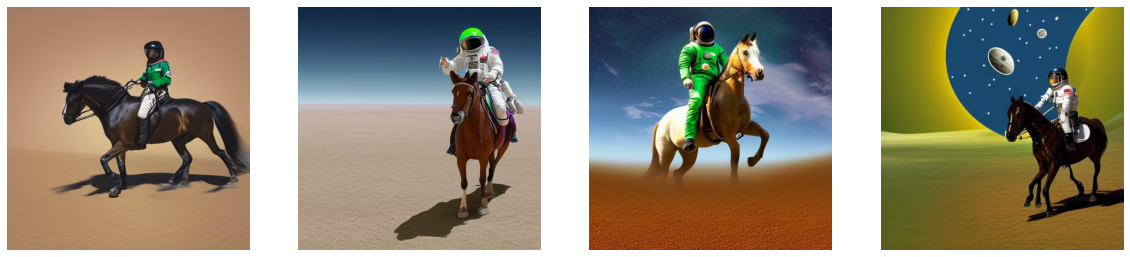

In [16]:
plot_images(tf.convert_to_tensor(json_response['outputs']).numpy())